# Strategies for Mathematical Trading

## Importing necessary libraries

In [249]:
import pandas as pd
import yfinance as yf
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

## Functions for calculation of indicator parameters

In [250]:
# https://finance.yahoo.com/news/stock-correlation-212133633.html?guccounter=1#:~:text=First%2C%20find%20the%20square%20of,each%20day%20in%20the%20period.
def corr_coef(dt1, dt2):
    return (dt1['Deviation']*dt2['Deviation']).sum()/(sqrt((dt1["Deviation"]**2).sum())*sqrt((dt2["Deviation"]**2).sum()))

In [251]:
#This function returns postive value if NSE is leading and negative if NASDAQ is leading
def lead_lag_rel(dt1, dt2, max_lag_time):
    cross_corr = [dt1.Close.corr(dt2.Close.shift(lag)) for lag in range(-max_lag_time, max_lag_time)]
    max_corr_index = cross_corr.index(max(cross_corr))

    return max(cross_corr), max_corr_index-max_lag_time

In [252]:
def calculate_keltner_channel(data, window=20, atr_win=10, atr_multiplier=2):
    # Calculate True Range (TR)
    data['H-L'] = data['High'] - data['Low']
    data['H-PC'] = abs(data['High'] - data['Close'].shift(1))
    data['L-PC'] = abs(data['Low'] - data['Close'].shift(1))
    data['TR'] = data[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    
    # Calculate Average True Range (ATR)
    data['ATR'] = data['TR'].ewm(atr_win).mean()
    
    # Calculate Keltner Channel
    data['KCUpperBand'] = data['Close'].ewm(window).mean() + atr_multiplier * data['ATR']
    data['KCLowerBand'] = data['Close'].ewm(window).mean() - atr_multiplier * data['ATR']
    data['KCMiddleBand'] = data['Close'].ewm(window).mean()
    
    return data[['KCUpperBand', 'KCMiddleBand', 'KCLowerBand']]

In [253]:

def calculate_bollinger_bands(data, window=20, num_std=2):
    # Calculate SMA and Standard Deviation
    sma = data['Close'].rolling(window).mean()
    std_dev = data['Close'].rolling(window).std()
    
    # Calculate Bollinger Bands
    data['BUpperBand'] = sma + num_std * std_dev
    data['BLowerBand'] = sma - num_std * std_dev
    
    return data[['BUpperBand', 'BLowerBand']]

In [254]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    # Calculate Exponential Moving Averages (EMA)
    ema_short = data['Close'].ewm(short_window).mean()
    ema_long = data['Close'].ewm(long_window).mean()
    
    # Calculate MACD Line
    macd_line = ema_short - ema_long
    
    # Calculate Signal Line
    signal_line = macd_line.ewm(signal_window).mean()
    
    # Calculate MACD Histogram
    macd_histogram = macd_line - signal_line
    
    data['MACD_Line'] = macd_line
    data['Signal_line'] = signal_line
    data['MACD_Histogram'] = macd_histogram
    
    return data[['MACD_Line', 'Signal_line', 'MACD_Histogram']]

In [255]:
def signal_generation_kc(data):
    data['Keltner_Signal']=data["Close"]*0
    signal=0
    for i in data.index:
        if data['Close'][i] < data['KCLowerBand'][i] and data['Close'].shift(-1)[i] > data['Close'][i]:
            if signal != 1:
                signal = 1
                data.loc[i, 'Keltner_Signal']=signal
            else:
                data.loc[i, 'Keltner_Signal']=signal
        elif data['Close'][i] > data['KCUpperBand'][i] and data['Close'].shift(-1)[i] < data['Close'][i]:
            if signal == 1:
                signal = 0
                data.loc[i, 'Keltner_Signal']=1
            else:
                data.loc[i, 'Keltner_Signal']=signal
        else:
            data.loc[i, 'Keltner_Signal']=signal
    data['Keltner_Returns'] = (data['Returns'] * data['Keltner_Signal'])
    #data['Keltner_Returns']=data['Keltner_Returns']/(np.where(data['Keltner_Signal']==1, data['Close'], 0).sum())

In [256]:
def signal_generation_b(data):
    data['Bollinger_Signal']=data["Close"]*0
    signal=0
    for i in data.index:
        if data['Close'][i] < data['BLowerBand'][i] and data['Close'].shift(-1)[i] > data['Close'][i]:
            if signal != 1:
                signal = 1
                data.loc[i, 'Bollinger_Signal']=signal
            else:
                data.loc[i, 'Bollinger_Signal']=signal
        elif data['Close'][i] > data['BUpperBand'][i] and data['Close'].shift(-1)[i] < data['Close'][i]:
            if signal == 1:
                signal = 0
                data.loc[i, 'Bollinger_Signal']=1
            else:
                data.loc[i, 'Bollinger_Signal']=signal
        else:
            data.loc[i, 'Bollinger_Signal']=signal
    #data['Bollinger_Signal'] = np.where((data['Close'] > data['BUpperBand']) & (data['Close']>data['Close'].shift(-1)) & (data['Bollinger_Signal'].shift(1)!=1), 1, np.where((data['Close'] < data['BLowerBand']) & (data['Close']<data['Close'].shift(-1)) & (data['Bollinger_Signal'].shift(1)!=-1), -1, 0))
    data['Bollinger_Returns'] = data['Returns'] * data['Bollinger_Signal']

In [257]:
def signal_generation_macd(data):
    data['MACD_Signal'] = np.where(data['MACD_Histogram'] > 0, 1, np.where(data['MACD_Histogram'] < 0, -1, 0))
    data['MACD_Returns'] = data['Returns'] * data['MACD_Signal']

In [258]:
def cumulative_returns(daily_returns):
    return ((1+daily_returns/100).cumprod()-1).tail(1).reset_index(drop=True)[0]*100

In [259]:
def sharpe_ratio(daily_returns):
    annualized_avg_return=daily_returns.mean()*252
    risk_free_return=4
    return (annualized_avg_return-risk_free_return)/(daily_returns.std()*sqrt(252))

In [260]:
def maximum_drawdown(daily_return):
    cum_max=daily_return.cummax()
    drawdowns=(daily_return-cum_max)/cum_max
    return drawdowns.min()

## Applying different strategies on the data

In [261]:
data=yf.download("^IXIC", start='2010-01-01', end='2023-05-01')
dt1=pd.DataFrame(data)
data=yf.download("^NSEI", start='2010-01-01', end='2023-05-01')
dt2=pd.DataFrame(data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [262]:
x_avg=dt1['Close'].mean()
dt1['Deviation']=dt1['Close']-x_avg
dt1['Returns'] = dt1['Close'].pct_change()
y_avg=dt2['Close'].mean()
dt2['Deviation']=dt2['Close']-y_avg
dt2['Returns'] = dt2['Close'].pct_change()
dt1

,Open,High,Low,Close,Adj Close,Volume,Deviation,Returns
Date,,,,,,,,
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1931380000,-4297.680510,NaN
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2308.709961,2367860000,-4297.390471,0.000126
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2301.090088,2253340000,-4305.010344,-0.003300
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2300.050049,2270050000,-4306.050383,-0.000452
2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2317.169922,2145390000,-4288.930510,0.007443
...,...,...,...,...,...,...,...,...
2023-04-24,12053.469727,12103.580078,11960.299805,12037.200195,12037.200195,4854050000,5431.099763,-0.002921
2023-04-25,11968.809570,11990.459961,11798.769531,11799.160156,11799.160156,4806020000,5193.059724,-0.019775
2023-04-26,11913.230469,11967.990234,11833.070312,11854.349609,11854.349609,5281970000,5248.249177,0.004677


In [263]:
corr_coef(dt1, dt2)

0.9142835706140554

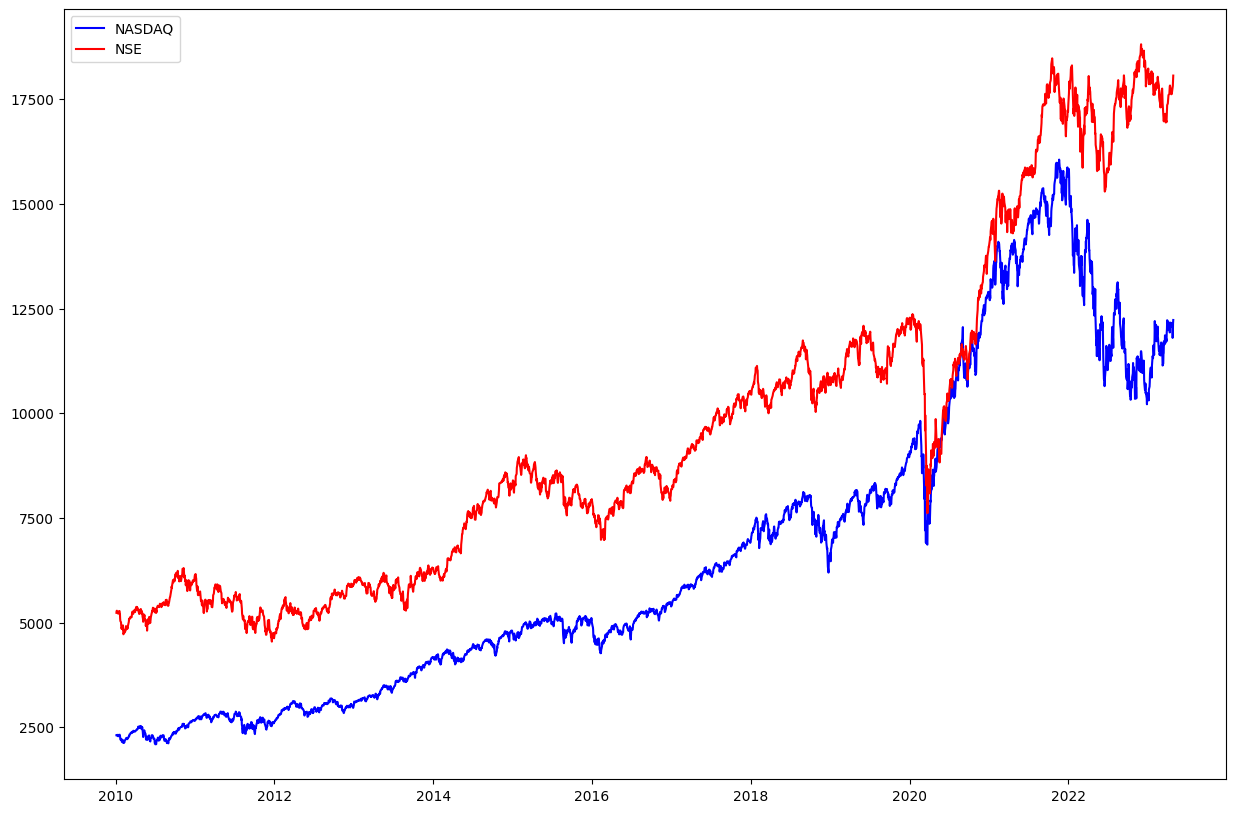

In [283]:
plt.figure(figsize=(15,10))
plt.plot(dt1.Close, '-b', label='NASDAQ')
plt.plot(dt2.Close, '-r', label='NSE')
plt.legend()

In [265]:
# tells us after a lag of how many days correlation maximises
# negative lag indicates NASDAQ is leading, positive indicates NSE is leading
# first value is the maximum correlation and the corresponding lag in days
lead_lag_rel(dt1, dt2, 200)

(0.9673330304839068, -150)

In [266]:
calculate_keltner_channel(dt1, 12, 11, 3)

,KCUpperBand,KCMiddleBand,KCLowerBand
Date,,,
2010-01-04,2358.639893,2308.419922,2258.199951
2010-01-05,2360.934862,2308.570742,2256.206622
2010-01-06,2359.257173,2305.875155,2252.493136
2010-01-07,2356.163924,2304.239658,2252.315393
2010-01-08,2366.040888,2307.255323,2248.469757
...,...,...,...
2023-04-24,12478.053506,11976.629817,11475.206129
2023-04-25,12482.224352,11962.978305,11443.732258
2023-04-26,12472.805314,11954.622251,11436.439189


In [267]:
calculate_bollinger_bands(dt1, 21, 3)

,BUpperBand,BLowerBand
Date,,
2010-01-04,NaN,NaN
2010-01-05,NaN,NaN
2010-01-06,NaN,NaN
2010-01-07,NaN,NaN
2010-01-08,NaN,NaN
...,...,...
2023-04-24,12456.373763,11624.007190
2023-04-25,12461.263413,11616.755653
2023-04-26,12443.880737,11642.282116


In [268]:
calculate_macd(dt1)

,MACD_Line,Signal_line,MACD_Histogram
Date,,,
2010-01-04,0.000000,0.000000,0.000000
2010-01-05,0.003065,0.001613,0.001452
2010-01-06,-0.105355,-0.037859,-0.067496
2010-01-07,-0.173279,-0.077236,-0.096043
2010-01-08,0.094868,-0.035210,0.130077
...,...,...,...
2023-04-24,186.992016,175.308338,11.683678
2023-04-25,172.987823,175.076286,-2.088463
2023-04-26,162.248098,173.793468,-11.545369


In [269]:
signal_generation_macd(dt1)
signal_generation_b(dt1)
signal_generation_kc(dt1)

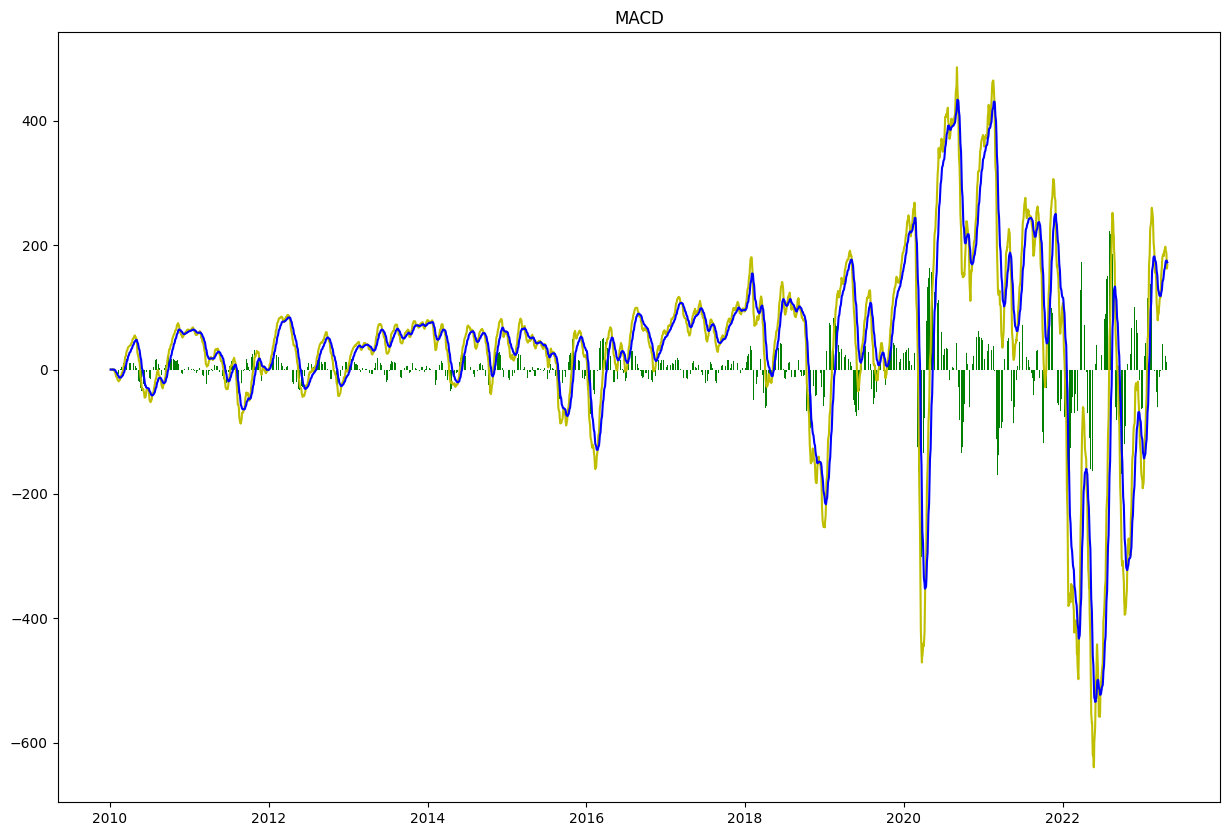

In [270]:
plt.figure(figsize=(15,10))
plt.plot(dt1['MACD_Line'], '-y')
plt.plot(dt1['Signal_line'], '-b', label='')
plt.bar(dt1.index, dt1['MACD_Histogram'], color='green', label='MACD Histogram')
plt.title('MACD')
plt.show()


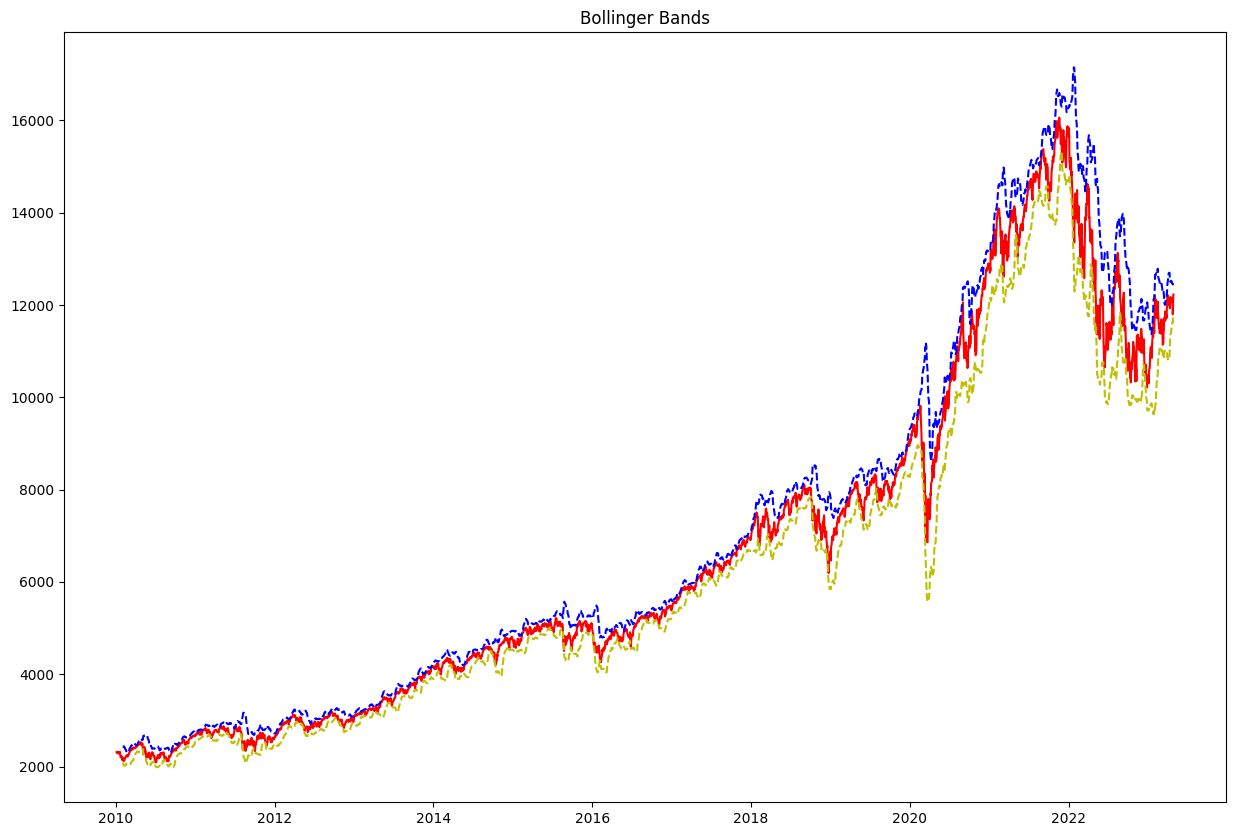

In [271]:
plt.figure(figsize=(15,10))
plt.plot(dt1['Close'], '-r')
plt.plot(dt1['BLowerBand'], '--y')
plt.plot(dt1['BUpperBand'], '--b')
plt.title('Bollinger Bands')
plt.show()

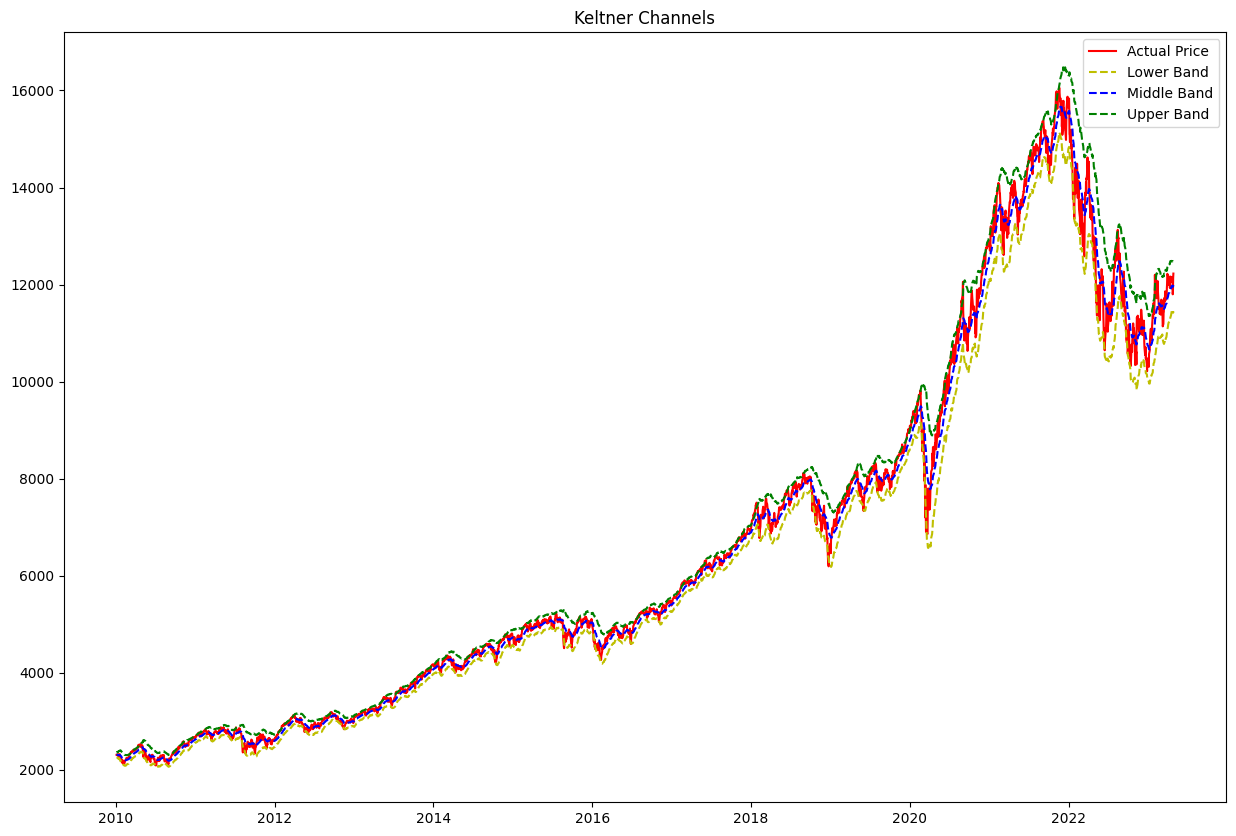

In [272]:
plt.figure(figsize=(15,10))
plt.plot(dt1['Close'], '-r', label='Actual Price')
plt.plot(dt1['KCLowerBand'], '--y', label='Lower Band')
plt.plot(dt1['KCMiddleBand'], '--b', label='Middle Band')
plt.plot(dt1['KCUpperBand'], '--g', label='Upper Band')
plt.title('Keltner Channels')
plt.legend()
plt.show()

In [273]:
print(cumulative_returns(dt1['Bollinger_Returns']*100), sharpe_ratio(dt1['Bollinger_Returns']*100), maximum_drawdown(dt1['Bollinger_Returns']))

427.0895761555454 0.5185650415317772 -2.616539175506242


In [274]:
print(cumulative_returns(dt1['Keltner_Returns']*100), sharpe_ratio(dt1['Keltner_Returns']*100), maximum_drawdown(dt1['Keltner_Returns']))

281.18442795820744 0.46014195671344776 -4.149814004180698


In [275]:
print(cumulative_returns(dt1['MACD_Returns']*100), sharpe_ratio(dt1['MACD_Returns']*100), maximum_drawdown(dt1['MACD_Returns']))


331.5577112219952 0.4422572074313002 -2.398740206275003


## Optimizing Parameter

In [276]:
# calculate_keltner_channel(dt1)
# signal_generation_kc(dt1)
# k1=cumulative_returns(dt1['Keltner_Returns']*100)
# opt_win, opt_atr_win, opt_std_mult=20, 10, 2
# for i in range(10, 40):
#     for j in range(5, i):
#         for k in range(1, 5):
#             calculate_keltner_channel(dt1, i, j, k)
#             signal_generation_kc(dt1)
#             k2=cumulative_returns(dt1['Keltner_Returns']*100)
#             if(k2>k1):
#                 k1=k2
#                 opt_win, opt_atr_win, opt_std_mult=i, j, k
#     print(opt_win, opt_atr_win, opt_std_mult, k1)

In [277]:
# calculate_bollinger_bands(dt1)
# signal_generation_b(dt1)
# k1=cumulative_returns(dt1['Bollinger_Returns']*100)
# opt_win, opt_std_mult=20, 2
# for i in range(10, 40):
#     for k in range(1, 5):
#         calculate_bollinger_bands(dt1, i, k)
#         signal_generation_b(dt1)
#         k2=cumulative_returns(dt1['Bollinger_Returns']*100)
#         if(k2>k1):
#             k1=k2
#             opt_win, opt_std_mult=i, k
#     print(opt_win, opt_std_mult, k1)

## Applying Optimized parameters on NSE

In [278]:
calculate_keltner_channel(dt2, 12, 11, 3)
calculate_bollinger_bands(dt2, 21, 3)
calculate_macd(dt2)
signal_generation_kc(dt2)
signal_generation_b(dt2)
signal_generation_macd(dt2)
dt2.head(10)

,Open,High,Low,Close,Adj Close,Volume,Deviation,Returns,H-L,H-PC,...,BLowerBand,MACD_Line,Signal_line,MACD_Histogram,Keltner_Signal,Keltner_Returns,Bollinger_Signal,Bollinger_Returns,MACD_Signal,MACD_Returns
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0,-4369.713088,NaN,71.350098,NaN,...,NaN,0.000000,0.000000,0.000000,0.0,NaN,0.0,NaN,0,NaN
2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0,-4324.013381,0.008734,45.950195,56.149902,...,NaN,0.482865,0.254139,0.228725,0.0,0.0,0.0,0.0,1,0.008734
2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0,-4320.113478,0.000739,50.800293,32.950195,...,NaN,0.686583,0.413713,0.272870,0.0,0.0,0.0,0.0,1,0.000739
2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0,-4338.813185,-0.003540,57.799805,20.750000,...,NaN,0.469364,0.429895,0.039469,0.0,-0.0,0.0,-0.0,1,-0.003540
2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0,-4357.163283,-0.003487,42.049805,13.649902,...,NaN,0.012787,0.328040,-0.315253,0.0,-0.0,0.0,-0.0,-1,0.003487
2010-01-11,5263.799805,5287.200195,5227.799805,5249.399902,5249.399902,0,-4352.513381,0.000887,59.400391,42.450195,...,NaN,-0.190483,0.217377,-0.407859,0.0,0.0,0.0,0.0,-1,-0.000887
2010-01-12,5251.100098,5300.500000,5200.950195,5210.399902,5210.399902,0,-4391.513381,-0.007429,99.549805,51.100098,...,NaN,-1.099954,-0.035129,-1.064825,0.0,-0.0,0.0,-0.0,-1,0.007429
2010-01-13,5212.600098,5239.200195,5169.549805,5233.950195,5233.950195,0,-4367.963088,0.004520,69.650391,28.800293,...,NaN,-1.260326,-0.250252,-1.010074,0.0,0.0,0.0,0.0,-1,-0.004520
2010-01-14,5234.500000,5272.850098,5232.500000,5259.899902,5259.899902,0,-4342.013381,0.004958,40.350098,38.899902,...,NaN,-0.821517,-0.343508,-0.478009,0.0,0.0,0.0,0.0,-1,-0.004958


In [279]:
print(cumulative_returns(dt2['MACD_Returns']*100), sharpe_ratio(dt2['MACD_Returns']*100), maximum_drawdown(dt2['MACD_Returns']))

375.77209887331816 0.5516728057218159 -2.271212090388785


In [280]:
print(cumulative_returns(dt2['Bollinger_Returns']*100), sharpe_ratio(dt2['Bollinger_Returns']*100), maximum_drawdown(dt2['Bollinger_Returns']))

126.80918261023012 0.27647067887488247 -2.56613638451474


In [281]:
print(cumulative_returns(dt2['Keltner_Returns']*100), sharpe_ratio(dt2['Keltner_Returns']*100), maximum_drawdown(dt2['Keltner_Returns']))

83.63990114278536 0.11860851369015452 -4.929056067266709
